### Exploratory Data Analysis

In this notebook, I individually explore each csv scraped. This particular notebook explores the *linkedin_business analyst.csv* file.

Firstly, I clean the data by removing rows with error (from scraping), removing duplicate rows and pre-process the job description, which is pretty messy due to the numerous html tags.

Next, I look at the frequency of job openings and popularity of jobs. I categorize the popularity of jobs into tiers, which is calculated based on a multiplication between number of applicants and how recent the job opening was posted.

Lastly, I explore the job descriptions. In particular, I fit the job descriptions into a Bag of Words model and output the top 30 occurring words/bigrams/trigrams/quadgrams. I plot some wordclouds too.

#### Import libraries

In [1]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import re
from collections import Counter
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
import string

#### Cleaner function

In [2]:
# Stop word list to filter noise in bag of words
stop_list = stopwords.words('english')

# All letters except for r, need to keep r because r represents R programming language
letters = string.ascii_lowercase[:17] + string.ascii_lowercase[18:]
letters_list = [letters[l] for l in range(len(letters))]

WNL = WordNetLemmatizer()

punct_list = [punctuation[p] for p in range(len(punctuation))]
add_stop_words = ['class', 'div', 'description__text', 'ul', 
                  'li', 'br', 'ul', 'job', 'description', 'rich', 
                  'strong', 'to', 'apply', 'visit', 'the', 'and',
                  'make', 'at', 'you', 'we', 'our', 'would', 'via',
                  'pte', 'ltd', 'us', 'please', 'lt', 'weight', 'gt',
                  'span', 'em']

stop_list += punct_list + add_stop_words + letters_list

def cleaner(x):
    output = []
    x = re.sub(r'<[\sa-zA-Z0-9=\-_/"]+>', ' ', x)
    for w in x.split():
        curr_word = WNL.lemmatize(w)
        curr_word = curr_word.lower()
        curr_word = re.sub(r'[^\w\s]', '', curr_word)
        if curr_word not in stop_list:
            output.append(curr_word)
    return ' '.join(output)

# stop_list

# Data Cleaning

#### Read csv and remove rows with error

In [3]:
thisfile = 'linkedin_business analyst.csv'
datafolder = './scraped_data/'

df = pd.read_csv(datafolder + thisfile)
print('Original number of csv rows: ' + str(df.shape[0]))

df = df.loc[df['Job Title'] != 'error']
print('\033[1m' + 'Number of rows without error from scraping: ' + str(df.shape[0]) + '\033[0m')

Original number of csv rows: 989
Number of rows without error from scraping: 989


#### Remove duplicates

In [4]:
duplicate_rows = df.duplicated(subset = ['Job Title', 'Company Name'], keep = 'first') # returns True for all 2nd duplicated rows
duplicate_rows_list = duplicate_rows.tolist()  

df = df[~duplicate_rows]
df = df.reset_index(drop = True)

print('Number of duplicate rows: ' + str(duplicate_rows_list.count(True)))
print('\033[1m' + 'number of unique rows: ' + str(df.shape[0]) + '\033[0m')

Number of duplicate rows: 77
number of unique rows: 912


#### Clean job description

In [5]:
print('\033[1m' + 'Before cleaning:' + '\033[0m')
print(df.iloc[3]['Job Description'])

df['Job Description'] =  df['Job Description'].replace(np.nan, '')
df['Job Description'] = df.apply(lambda x: cleaner(x['Job Description']), axis = 1)

print('\033[1m' + '\nAfter cleaning: ' + '\033[0m')
print(df.iloc[3]['Job Description'])

Before cleaning:
<div class="show-more-less-html__markup show-more-less-html__markup--clamp-after-5"><u>Scope of Work<br/></u><ul> <li>Perform business analysis such as assess current state analyses stated requirements of stakeholders to define business needs;</li> <li>Source and evaluate alternatives to identify solution that best fits business need identify gaps and determine workarounds/changes to the solution. Assess deployed solutions to see how well they met the original need;</li> <li>Work closely with business users and project team members on project initiation solution design implementation deployment and post implementation support;</li> <li>Lead the solution design effort and help to develop innovative solutions while complying to existing standards guidelines and processes; and</li> <li>Manage conflicts issues and changes to ensure stakeholders and project team remain in agreement on solution scope communicate and manage expectations of stakeholders.</li> <br/><br/></ul><s

# Frequency Of Job Openings

#### Remove rows without date or older than a year

In [6]:
print('Number of rows: ' + str(df.shape[0]))
gotdate_df = df
years_df = df.loc[df['When Posted'].str.contains('year')]
drop_these_rows = []

for index, row in years_df.iterrows():
    drop_these_rows.append(index)
for i in drop_these_rows:
    gotdate_df.drop(i, axis = 0, inplace = True)
print('Number of rows with date older than 1 year: ' + str(len(drop_these_rows)))

gotdate_df = gotdate_df.reset_index(drop = True) # Reset the index
nodate_df = df.loc[df['When Posted'] == 'nil']
print('Number of rows without date: ' + str(nodate_df.shape[0]))

gotdate_df = gotdate_df.loc[gotdate_df['When Posted'] != 'nil']
print('\033[1m' + 'Number of rows after cleaning date: ' + str(gotdate_df.shape[0]) + '\033[0m') # proceed with gotdate_df

Number of rows: 912
Number of rows with date older than 1 year: 1
Number of rows without date: 16
Number of rows after cleaning date: 895


#### Create Binned_Weeks column

In [7]:
# Convert When Posted to weeks
def week_converter(x):
    if x == 'nil':
        return 'nil'
    ans = int(x[0])
    if 'day' in x:
        return round(ans/7, 3)
    elif 'week' in x:
        return int(ans)
    elif 'month' in x:
        return int(ans*4)

# Convert weeks to Binned_Weeks
def binned_weeks_converter(x):
    if x < 1:
        return '<1'
    elif x == 1:
        return '1'
    elif x == 2:
        return '2'
    elif (x == 3) or (x == 4):
        return '3-4'
    elif (x >= 5) and (x <= 8):
        return '5-8'
    else:
        return '>8'

In [8]:
# Create Weeks and Binned_Weeks columns
gotdate_df['Weeks'] = gotdate_df.apply(lambda x: week_converter(x['When Posted']), axis = 1)
gotdate_df['Binned_Weeks'] = gotdate_df.apply(lambda x: binned_weeks_converter(x['Weeks']), axis = 1)
gotdate_df.head()

,Job Title,Company Name,Country,When Posted,No. of Applicants,Hyperlink,Job Description,Weeks,Binned_Weeks
0,Apple Support Business Analyst,Apple,Singapore| Singapore,4 weeks ago,55 applicants,https://sg.linkedin.com/jobs/view/apple-suppor...,summary imagine could apple great idea way bec...,4.000,3-4
1,Business Analyst,One North,Singapore| Singapore,4 days ago,Be among the first 25 applicants,https://sg.linkedin.com/jobs/view/business-ana...,requirements role indepth understanding busine...,0.571,<1
2,IKEA Jurong - Business Analyst,IKEA,Singapore| Singapore,6 days ago,Over 200 applicants,https://sg.linkedin.com/jobs/view/ikea-jurong-...,company ikea vision create better everyday lif...,0.857,<1
3,Business Analyst #SGUnited,Kydon Group,Singapore| Singapore,4 weeks ago,Be among the first 25 applicants,https://sg.linkedin.com/jobs/view/business-ana...,scope work perform business analysis ass curre...,4.000,3-4
4,Business Analyst,Tata Consultancy Services,Singapore| Singapore,2 days ago,165 applicants,https://sg.linkedin.com/jobs/view/business-ana...,desired competencies technicalbehavioral compe...,0.286,<1


#### Bar chart of job posting frequency

In [9]:
# Create Temp DF for Plotting Bar Chart
binned_weeks_df = gotdate_df.groupby('Binned_Weeks').count()
binned_weeks_series = binned_weeks_df.iloc[:, 0]
temp_df = pd.DataFrame({'Binned_Weeks':binned_weeks_series.index, 'Count':binned_weeks_series.values})

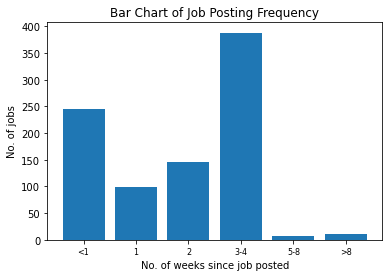

In [10]:
x = ['<1', '1', '2', '3-4', '5-8', '>8']
y = []

for i in x:
    for index, row in temp_df.iterrows():
        if i == row['Binned_Weeks']:
            y.append(row['Count'])

plt.bar(x,y)
plt.xlabel('No. of weeks since job posted')
plt.ylabel('No. of jobs')
plt.title('Bar Chart of Job Posting Frequency')
xticks = plt.xticks(x, rotation = 'horizontal', size = 8)

plt.show()

# Popularity Of Jobs

Popularity of jobs are tiered based on multiplication between number of applicants and how long ago the job was posted. In general, popular jobs are those with many applicants within a short window after the job opening is posted. The tiers range from:
- God tier
- A
- B
- C
- D

#### Functions to calculate score and tier

In [11]:
def tier_calc(score):
    if score >= 3000:
        tier = 'God tier'
    elif score >= 1000:
        tier = 'A'
    elif score >= 500:
        tier = 'B'
    elif score >= 300:
        tier = 'C'
    else:
        tier = 'D'
    return tier

def score_calc(weeks, numapp):
    # A = number of applicants
    if '200' in numapp:
        A = 65
    elif 'Be' in numapp:
        A = 10
    elif int(numapp.split(' ')[0]) >= 150:
        A = 50
    elif int(numapp.split(' ')[0]) >= 100:
        A = 35
    elif int(numapp.split(' ')[0]) >= 50:
        A = 20
    elif int(numapp.split(' ')[0]) >= 25:
        A = 15
    else:
        pass
    
    # B = recency of job post
    if weeks == 'nil':
        weeks = float(gotdate_df.median()) # if no date, set default value to median
    if weeks <= 0.429:
        B = 55
    elif weeks < 1:
        B = 50
    elif weeks == 1:
        B = 45
    elif weeks <= 3:
        B = 40
    elif weeks <= 5:
        B = 35
    elif weeks <= 8:
        B = 30
    else:
        B = 20
    
    score = A*B
    return score

#### Histogram of job popularity tiers

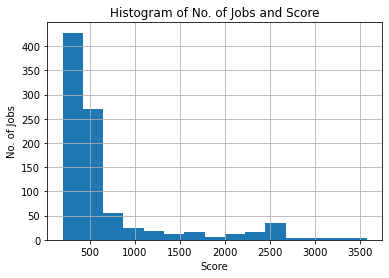

In [12]:
pop_df = df
pop_df['Weeks'] = df.apply(lambda x: week_converter(x['When Posted']), axis = 1)
pop_df['Score'] = pop_df.apply(lambda x: score_calc(x['Weeks'], x['No. of Applicants']), axis = 1)

pop_df.hist(column='Score', bins=15)

plt.xlabel('Score')
plt.ylabel('No. of Jobs')
plt.title('Histogram of No. of Jobs and Score')

plt.show()

In [13]:
pop_df['Tier'] = pop_df['Score'].apply(lambda x: tier_calc(x))

In [14]:
# God Tier jobs
pop_df.loc[pop_df['Tier'] == 'God tier'].head(3)

,Job Title,Company Name,Country,When Posted,No. of Applicants,Hyperlink,Job Description,Weeks,Score,Tier
2,IKEA Jurong - Business Analyst,IKEA,Singapore| Singapore,6 days ago,Over 200 applicants,https://sg.linkedin.com/jobs/view/ikea-jurong-...,company ikea vision create better everyday lif...,0.857,3250,God tier
59,Business Analyst| Customer Solutions & Growth|...,Johnson Controls,Singapore| Singapore,5 days ago,Over 200 applicants,https://sg.linkedin.com/jobs/view/business-ana...,position report director apac customer solutio...,0.714,3250,God tier
67,Strategy Analyst,Zespri International,Singapore| Singapore,4 days ago,Over 200 applicants,https://sg.linkedin.com/jobs/view/strategy-ana...,zespri simply worlds singlelargest marketer ki...,0.571,3250,God tier


In [15]:
# B Tier jobs
pop_df.loc[pop_df['Tier'] == 'A'].head(3)

,Job Title,Company Name,Country,When Posted,No. of Applicants,Hyperlink,Job Description,Weeks,Score,Tier
4,Business Analyst,Tata Consultancy Services,Singapore| Singapore,2 days ago,165 applicants,https://sg.linkedin.com/jobs/view/business-ana...,desired competencies technicalbehavioral compe...,0.286,2750,A
6,Business Analyst (Digital),Chubb,Singapore| Singapore,2 days ago,109 applicants,https://sg.linkedin.com/jobs/view/business-ana...,chubb looking business analyst join regional d...,0.286,1925,A
10,IT Business Analyst,Scoot,Singapore| Singapore,6 days ago,148 applicants,https://sg.linkedin.com/jobs/view/it-business-...,primary role involve participating design deli...,0.857,1750,A


In [16]:
# D Tier jobs
pop_df.loc[pop_df['Tier'] == 'D'].head(3)

,Job Title,Company Name,Country,When Posted,No. of Applicants,Hyperlink,Job Description,Weeks,Score,Tier
467,Regional Claims Business and Reporting Analyst,Chubb,Singapore,3 months ago,Be among the first 25 applicants,https://sg.linkedin.com/jobs/view/regional-cla...,position primarily responsible reporting analy...,12,200,D
549,Senior IFRS 17 Business Solution Lead/Analyst,Chubb,Singapore,3 months ago,Be among the first 25 applicants,https://sg.linkedin.com/jobs/view/senior-ifrs-...,ifrs 17 international insurance accounting sta...,12,200,D
555,Business Application Analyst (Migration/Cloud),Adecco,Singapore| Singapore,4 months ago,Be among the first 25 applicants,https://sg.linkedin.com/jobs/view/business-app...,talent two year experience functional business...,16,200,D


#### Barchart of job tiers

In [17]:
# Create temp df for plotting bar chart
binned_pop_df = pop_df.groupby('Tier').count()
binned_pop_series = binned_pop_df.iloc[:, 0]
temp_pop_df = pd.DataFrame({'Tier':binned_pop_series.index, 'Count':binned_pop_series.values})

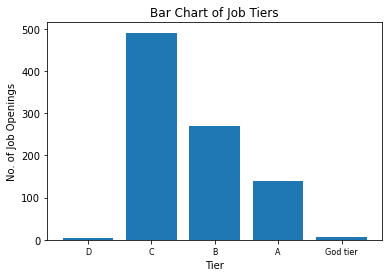

In [18]:
x = ['D', 'C', 'B', 'A', 'God tier']
y = []

for i in x:
    for index, row in temp_pop_df.iterrows():
        if i == row['Tier']:
            y.append(row['Count'])

plt.bar(x,y)
plt.xlabel('Tier')
plt.ylabel('No. of Job Openings')
plt.title('Bar Chart of Job Tiers')
xticks = plt.xticks(x, rotation = 'horizontal', size = 8)

plt.show()

# Job Description

In [19]:
# Bag of Words
master_bow = df['Job Description'].values.tolist()

#### Unigram

In [20]:
# Fit into countvectorizer
vectorizer = CountVectorizer(ngram_range=(1,1),
                             analyzer = 'word',  
                             tokenizer = None,  
                             preprocessor = None, 
                             stop_words = None,  
                             token_pattern = r"(?u)\b\w+\b")

vectorizer.fit(master_bow)
vector = vectorizer.transform(master_bow)

# Create DF with vocab as column and doc as rows
vocab = vectorizer.get_feature_names()
rows = vector.toarray()
vect_df = pd.DataFrame(rows, columns = vocab)

# Get top 30 occurring words
vocab_sum = vect_df.sum(axis = 0)
ans = vocab_sum.sort_values(axis = 0, ascending = False)
ans[:30]

business         5331
experience       2808
team             2594
data             1952
project          1948
work             1825
management       1756
requirement      1546
skill            1510
support          1449
process          1323
solution         1272
technology       1259
analysis         1239
system           1158
ability          1076
analyst          1047
working          1020
development      1002
knowledge         991
user              942
product           933
stakeholder       919
client            905
ensure            813
role              808
service           805
application       787
communication     777
design            756
dtype: int64

#### Bigram

In [21]:
# Fit into countvectorizer
vectorizer = CountVectorizer(ngram_range=(2,2),
                             analyzer = 'word',  
                             tokenizer = None,  
                             preprocessor = None, 
                             stop_words = None,  
                             token_pattern = r"(?u)\b\w+\b")

vectorizer.fit(master_bow)
vector = vectorizer.transform(master_bow)

# Create DF with vocab as column and doc as rows
vocab2 = vectorizer.get_feature_names()
rows2 = vector.toarray()
vect_df = pd.DataFrame(rows2, columns = vocab2)

# Get top 30 occurring bigrams
vocab2_sum = vect_df.sum(axis = 0)
ans2 = vocab2_sum.sort_values(axis = 0, ascending = False)
ans2[:30]

business analyst        465
business requirement    376
communication skill     317
business analysis       277
project management      255
business process        231
year experience         223
work closely            221
team player             211
skill ability           202
business need           200
ability work            185
problem solving         184
best practice           168
experience business     162
computer science        159
business user           158
experience working      158
bachelors degree        157
working experience      147
project team            138
able work               138
analytical skill        136
data analysis           135
5 year                  131
subject matter          127
development team        123
year relevant           123
project manager         121
software development    117
dtype: int64

#### Trigram

In [22]:
# Fit into countvectorizer
vectorizer = CountVectorizer(ngram_range=(3,3),
                             analyzer = 'word',  
                             tokenizer = None,  
                             preprocessor = None, 
                             stop_words = None,  
                             token_pattern = r"(?u)\b\w+\b")

vectorizer.fit(master_bow)
vector = vectorizer.transform(master_bow)

# Create DF with vocab as column and doc as rows
vocab3 = vectorizer.get_feature_names()
rows3 = vector.toarray()
vect_df = pd.DataFrame(rows3, columns = vocab3)

# Get top 30 occurring trigrams
vocab3_sum = vect_df.sum(axis = 0)
ans3 = vocab3_sum.sort_values(axis = 0, ascending = False)
ans3[:30]

written communication skill             71
problem solving skill                   69
degree computer science                 68
written verbal communication            68
user acceptance testing                 68
subject matter expert                   66
experience business analyst             63
view eeo law                            62
equal opportunity employer              61
year working experience                 59
verbal written communication            57
excellent communication skill           57
year relevant experience                52
5 year experience                       51
sexual orientation gender               50
good team player                        50
analytical problem solving              50
orientation gender identity             47
development life cycle                  47
business analysis experience            46
experience business analysis            45
click view eeo                          45
ability work independently              44
shortlisted

#### Quadgram

In [23]:
# Fit into countvectorizer
vectorizer = CountVectorizer(ngram_range=(4,4),
                             analyzer = 'word',  
                             tokenizer = None,  
                             preprocessor = None, 
                             stop_words = None,  
                             token_pattern = r"(?u)\b\w+\b")

vectorizer.fit(master_bow)
vector = vectorizer.transform(master_bow)

# Create DF with vocab as column and doc as rows
vocab4 = vectorizer.get_feature_names()
rows4 = vector.toarray()
vect_df = pd.DataFrame(rows4, columns = vocab4)

# Get top 30 occurring quadgrams
vocab4_sum = vect_df.sum(axis = 0)
ans4 = vocab4_sum.sort_values(axis = 0, ascending = False)
ans4[:30]

sexual orientation gender identity           47
verbal written communication skill           40
united overseas bank limited                 36
overseas bank limited uob                    36
equal opportunity affirmative action         35
opportunity affirmative action employer      35
written verbal communication skill           34
need reasonable accommodation use            32
without regard race color                    32
citi invite qualified interested             31
ambitions view information benefit           31
inc subsidiary citi invite                   31
citigroup inc subsidiary citi                31
accommodation use search tool                31
opportunities person disability need         31
citi equal opportunity affirmative           31
invite qualified interested applicant        31
person disability need reasonable            31
benefit including flexible working           31
use search tool andor                        31
disability need reasonable accommodation

## WordCloud

#### Unigram WordCloud

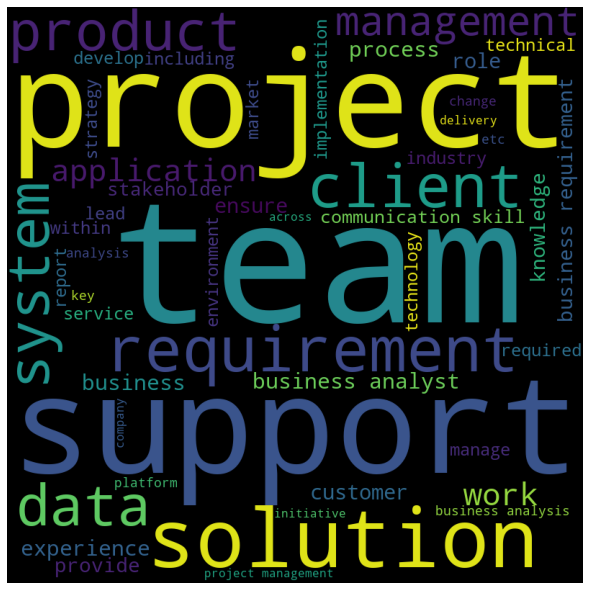

In [24]:
single_master_bow = ''
for bow in master_bow:
    single_master_bow += bow + ' '
    

wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='black', 
            min_font_size = 10,
            max_words = 50).generate(single_master_bow) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#### Bigram WordCloud

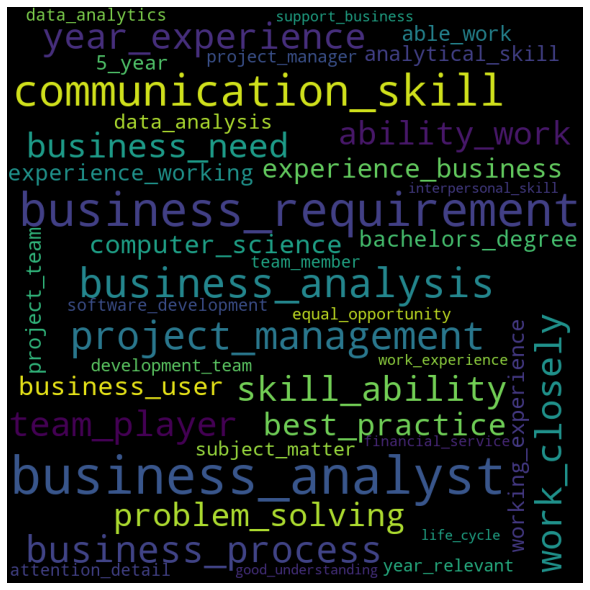

In [25]:
if type(vocab2) != list:
    vocab2 = vocab2.tolist()

vocab_2 = []

# Replace space with _
for bigram in vocab2:
    vocab_2.append(bigram.replace(' ', '_'))

if type(vocab2_sum) != list:
    vocab2_sum = vocab2_sum.tolist()

bigram_dict = {}
for i in range(len(vocab2_sum)):
    bigram_dict[vocab_2[i]] = vocab2_sum[i]
    
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='black', 
            regexp = None,
            min_font_size = 10,
            max_words = 40).generate_from_frequencies(bigram_dict)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()